In [1]:
import matplotlib.pyplot as plt
import random
from random import randint
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import trackhhl.toy.simple_generator as toy
import time
import tracemalloc

In [2]:
class agent:
    def __init__(self, angle_window, extrapolation_uncertainty, extrapolation_range = 0):
        self.angle_window = angle_window
        self.extrapolation_uncertainty = extrapolation_uncertainty # rounding -> number of decimal points
        self.extrapolation_range = extrapolation_range # number of layers range
    
    def get_segments(self, event):
        seg = []
        for i in range(len(event.modules) - 1):
            this_layer = []
            for hit1 in event.modules[i].hits:
                for hit2 in event.modules[i + 1].hits:
                    this_layer.append([[hit1.x, hit1.y, hit1.z], [hit2.x, hit2.y, hit2.z]])
            seg.append(this_layer)
        return seg

    def plot_tracks(self, array, title):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        if len(array) > 1:
            for track in array:
                for i in range(len(track) - 1):
                    ax.plot([track[i][0], track[i + 1][0]], [track[i][1], track[i + 1][1]], [track[i][2], track[i + 1][2]], 'ro-')
        if len(array) == 1:
            for i in range(len(array) - 1):
                    ax.plot([array[i][0], array[i + 1][0]], [array[i][1], array[i + 1][1]], [array[i][2], array[i + 1][2]], 'ro-')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(title)
        plt.grid(True)
        plt.show()

    def is_straight(self, seg1, seg2):
        isit = False
        #seg = ((x1, y1, z1), (x2, y2, z2))
        #vector_seg = (X, Y, Z)
        vector_seg1 = [seg1[0][0] - seg1[1][0], seg1[0][1] - seg1[1][1], seg1[0][2] - seg1[1][2]]
        vector_seg2 = [seg2[0][0] - seg2[1][0], seg2[0][1] - seg2[1][1], seg2[0][2] - seg2[1][2]]
        len_v1 = np.linalg.norm(vector_seg1)
        len_v2 = np.linalg.norm(vector_seg2)
        cos_a = np.dot(vector_seg1, vector_seg2)/(len_v1*len_v2)
        if 1 - cos_a < self.angle_window :
            isit = True
        return isit
            
    def find_candidates(self, event):
        array = self.get_segments(event)
        candidates = []
        #all_seg[0] = first layer segments
        for anchor in array[0]:
            for segment in array[1]:
                if self.is_straight(anchor, segment):
                    candidates.append(anchor + segment)
        return candidates

    def find_tracks(self, event):
        array = self.find_candidates(event)
        for candidate in array:
            if self.extrapolation_range == 0:
                end = len(event.modules)
            else:
                end = 3 + self.extrapolation_range
            for layer in range(3, end):
                for hit in event.modules[layer].hits:
                    t_x = (candidate[0][0]-hit.x)/(candidate[0][0]-candidate[3][0])
                    t_y = (candidate[0][1]-hit.y)/(candidate[0][1]-candidate[3][1])
                    t_z = (candidate[0][2]-hit.z)/(candidate[0][2]-candidate[3][2])
                    if round(t_x, self.extrapolation_uncertainty) == round(t_y, self.extrapolation_uncertainty) == round(t_z, self.extrapolation_uncertainty):
                        candidate.append([hit.x, hit.y, hit.z])
        return array


In [3]:
def make_event(N_MODULES, N_PARTICLES):
    LX = float("+inf")
    LY = float("+inf")
    Z_SPACING = 1.0
    detector = toy.SimpleDetectorGeometry(
        module_id=list(range(N_MODULES)),
        lx=[LX]*N_MODULES,
        ly=[LY]*N_MODULES,
        z=[i+Z_SPACING for i in range(N_MODULES)])
    generator = toy.SimpleGenerator(
        detector_geometry=detector,
        theta_max=np.pi/6)
    ev = generator.generate_event(N_PARTICLES)
    return ev

In [4]:
#GA parameters:
pop_size = 10
fit_size = int(pop_size/2 - 1)

max_pop_score = []
mean_pop_score = []
mean_runtimes = []
best_runtimes = []
best_ind = [0, [0, 0]]
runtimes = []

PARTICLES = 5
LAYERS = 10
event = make_event(LAYERS, PARTICLES)

In [5]:
def init(size):
    population = []
    for i in range(size):
        exp = random.uniform(0, 1)
        rounded = randint(1, 10)
        individual = [exp, rounded]
        population.append(individual)
    return population

def evaluate(ind):
    global runtimes
    print("evaluating: " + str(ind))
    angle_window, dec_places = ind
    start_time = time.time()
    this_agent = agent(angle_window, dec_places)
    agent_tracks = this_agent.find_tracks(event)
    end_time = time.time()

    # found as many tracks as there are particles? 
    tracks_found_score = len(agent_tracks)/PARTICLES
    if tracks_found_score > 1:
        tracks_found_score = 0

    # how fast is the agent?
    agent_runtime = end_time - start_time
    runtimes.append(agent_runtime)
    runtime_score = max(1 - agent_runtime/np.mean(runtimes), 0) 
    
    # if runtime is bigger than average ratio will be negative therefore the score will be 0

    # are the tracks as long as the amount of layers?
    crosspoints = 0
    tracks_length = []
    for track1 in agent_tracks: 
        tracks_length.append(len(track1))
        # are there duplicate tracks?
        for track2 in agent_tracks: 
            if track1 == track2:
                crosspoints += 1 
    crosshits_score = max(1 - crosspoints/len(agent_tracks), 0)
    length_score = np.mean(tracks_length)/(LAYERS-1)
    if length_score > 1:
        length_score = 0
    """
    print("n tracks found: " + str(len(agent_tracks)))
    print("n tracks found score: " + str(tracks_found_score))
    print("runtime score: " + str(runtime_score))
    print("length_score: " + str(length_score))
    print("unique tracks score: " + str(crosshits_score))
    """
    score = (tracks_found_score + 
             runtime_score + 
             length_score + 
             crosshits_score)/4
    
    print("score: " + str(score))
    return score

    
def get_fit(population):
    global best_ind, runtimes
    evaluated_pop = []
    scores = []
    # storing the scores of all tracks
    for ind1 in population:
        ind_score = evaluate(ind1)
        evaluated_pop.append([ind_score, ind1])
        scores.append(ind_score)
    av_score = np.mean(scores)
    print("av_score: " + str(av_score))

    fittest = []
    for i in evaluated_pop:
        this_score = i[0]
        if this_score > av_score:
            fittest.append([i])
            print("added to fittest: " + str(i[1]))
    
    print("n fit before: " + str(len(fittest)))
    fittest.sort(key=lambda tup:tup[0], reverse=False)
    while len(fittest) > fit_size:
        print("pop: " + str(fittest[0]))
        fittest.pop(0)
    
    # uploading best track
    for fit in fittest:
            if fit[1] != best_ind[1] and fit[0] >= best_ind[0]:
                print("NEW best individual: " + str(best_ind))
                best_ind = fit
                best_run_start = time.time()
                best_agent = agent(best_ind[1][0], best_ind[1][1])
                best_agent.find_tracks(event)
                best_run_end = time.time()
                best_rt = best_run_end - best_run_start
                best_runtimes.append(best_rt)
        
    # keeping track of evolution
    max_pop_score.append(max(scores))
    mean_pop_score.append(av_score)
    final_fittest = []
    for r in fittest:
        final_fittest.append(r[1])
    mean_runtimes.append(np.mean(runtimes))
    runtimes = []
    return final_fittest

def mutate(group):
    if len(group) > 0:
        offsprings = []
        print(str(len(group[0])))
        for ind in group:
            pam = randint(0, 1)
            if pam == 0:
                ind = [random.uniform(0, 1), ind[1]]
            if pam == 1:
                ind = [ind[0], randint(1, 10)]
            offsprings.append(ind)
    return offsprings


In [6]:
def main(max_gen, population_size, event):
    POPULATION = init(population_size)
    GENERATION = 0
    while GENERATION < max_gen:
        print("gen: " + str(GENERATION))
        fit = get_fit(POPULATION)
        #os = mutate(fit)
        #other = init(population_size - (len(fit) + len(os)))
        other = init(population_size - len(fit))
        print("n fit after: " + str(len(fit)))
        print()
        POPULATION = fit + other
        GENERATION += 1
    best_agent = agent(best_ind[1][0], best_ind[1][1])
    print()
    print("final best: " + str(best_ind))
    best_tracks = best_agent.find_tracks(event)
    print(str(len(best_tracks)) + " tracks found")
    print()
    print(best_tracks)
    #best_agent.plot_tracks(best_tracks, '3D tracks from best agent')

In [7]:

max_score_rdata = []
mean_score_rdata = []
mean_runtime_rdata = []
runtime_difference = []
non_op_time_start = time.time()
agent_1 = agent(1e-4, 3)
tracks_1 = agent_1.find_tracks(event)
non_op_time_end = time.time()
non_op_runtime = non_op_time_end - non_op_time_start

for i in range(10):
    max_pop_score = []
    mean_pop_score = []
    mean_runtimes = []
    best_runtimes = []
    best_ind = [0, [0, 0]]
    runtimes = [0]
    main(max_gen=100, population_size=pop_size, event=event)
    max_score_rdata.append(max_pop_score)
    mean_score_rdata.append(mean_pop_score)
    mean_runtime_rdata.append(mean_runtimes)
    op_time_start = time.time()
    best_agent = agent(best_ind[1][0], best_ind[1][1])
    best_tracks = best_agent.find_tracks(event)
    op_time_end = time.time()
    op_runtime = op_time_end - op_time_start

    print()
    print("final best: " + str(best_ind))
    print(str(len(best_tracks)) + " tracks found")
    print()
    print(best_tracks)
    print()
    print("Runtime before: " + str(non_op_runtime))
    print("Runtime after: " + str(op_runtime))
    runtime_difference.append(non_op_runtime-op_runtime)
#print(tracks_1)
#agent_1.plot_tracks(tracks_1, '3D tracks')

gen: 0
evaluating: [0.9819312308052944, 8]
score: 0.1443007662835249
evaluating: [0.9270228069148475, 1]
score: 0.14449360865290067
evaluating: [0.12513655346256203, 4]
score: 0.24893411849278713
evaluating: [0.3629435295100688, 4]
score: 0.14473262888248478
evaluating: [0.6391421874577631, 7]
score: 0.14365942028985507
evaluating: [0.8079296609649431, 5]
score: 0.14437134502923976
evaluating: [0.919015430538105, 7]
score: 0.1445527974783294
evaluating: [0.5494014336403155, 1]
score: 0.14473001038421598
evaluating: [0.30724028372264545, 4]
score: 0.17791982663320205
evaluating: [0.34562173268722474, 6]
score: 0.18598708037440118
av_score: 0.1623681602500941
evaluating: [0.9819312308052944, 8]
score: 0.1443007662835249
evaluating: [0.9270228069148475, 1]
score: 0.14449360865290067
evaluating: [0.12513655346256203, 4]
score: 0.2751626722869628
added to fittest: [0.12513655346256203, 4]
evaluating: [0.3629435295100688, 4]
score: 0.1750329636389153
added to fittest: [0.3629435295100688, 4]

In [28]:
#finding the average generation at which the max score is found
def find_average_index(array):
    indices = []
    for run in array:
        indices.append(run.index(max(run)))
    print("average index: " + str(np.mean(indices)))
    print("min: " + str(min(indices)))
    print("max: " + str(max(indices)))
    print(np.sort(indices))
find_average_index(max_score_rdata)

average index: 47.4
min: 4
max: 92
[ 4  7  9 12 60 63 69 73 85 92]


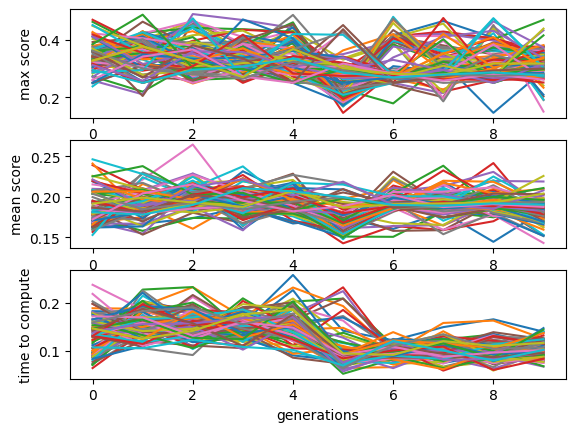

In [8]:
plt.subplot(3, 1, 1)
plt.plot(max_score_rdata)
plt.ylabel("max score")


plt.subplot(3, 1, 2)
plt.plot(mean_score_rdata)
plt.ylabel("mean score")


plt.subplot(3, 1, 3)
plt.plot(mean_runtime_rdata)
plt.ylabel("time to compute")

plt.xlabel("generations")


plt.show()

In [9]:
print(str(len(max_score_rdata)))
for list in max_score_rdata:
    print(str(len(list)))

def mean_array(array):
    averages = []
    for col in zip(*array):
        averages.append((sum(col)/len(col)))
    return averages

max_score_data = mean_array(max_score_rdata)
max_score_data = np.array(max_score_data)
df = pd.DataFrame(max_score_data)
df.to_csv("C:\\Users\\Surface\\Documents\\Uni stuff\\BTR\\DATA\\max_score_data_without_mut.csv")

mean_score_data = mean_array(mean_score_rdata)
mean_score_data = np.array(mean_score_data)
df = pd.DataFrame(mean_score_data)
df.to_csv("C:\\Users\\Surface\\Documents\\Uni stuff\\BTR\\DATA\\mean_score_data_without_mut.csv")

mean_runtime_data = mean_array(mean_runtime_rdata)
mean_runtime_data = np.array(mean_runtime_data)
df = pd.DataFrame(mean_runtime_data)
df.to_csv("C:\\Users\\Surface\\Documents\\Uni stuff\\BTR\\DATA\\mean_runtime_data_without_mut.csv")

10
100
100
100
100
100
100
100
100
100
100


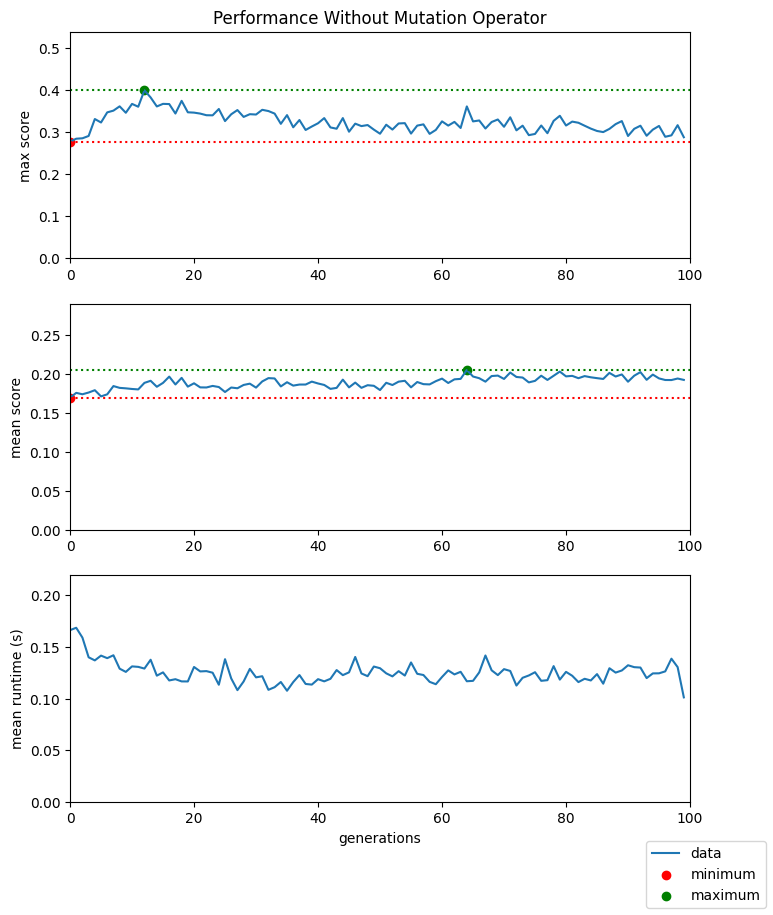

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))


ax1.set_title("Performance Without Mutation Operator")
ax1.plot(max_score_data)
x_point = np.where(max_score_data == min(max_score_data))
y_point = min(max_score_data)
ax1.scatter(x_point, y_point, color="red")
x_point = np.where(max_score_data == max(max_score_data))
y_point = max(max_score_data)
ax1.scatter(x_point, y_point, color="green")
ax1.axhline(y=min(max_score_data), color='r', linestyle='dotted')
ax1.axhline(y=max(max_score_data), color='g', linestyle='dotted')
ax1.set_ylabel("max score")
ax1.set_xlim(0, 100)
ax1.set_ylim(0, max(max_score_data) + (min(max_score_data) / 2))


ax2.plot(mean_score_data)
ax2.axhline(y=min(mean_score_data), color='r', linestyle='dotted')
ax2.axhline(y=max(mean_score_data), color='g', linestyle='dotted')
x_point = np.where(mean_score_data == min(mean_score_data))
y_point = min(mean_score_data)
ax2.scatter(x_point, y_point, color="red", label="minimum")
x_point = np.where(mean_score_data == max(mean_score_data))
y_point = max(mean_score_data)
ax2.scatter(x_point, y_point, color="green", label="maximum")
ax2.set_ylabel("mean score")
ax2.set_xlim(0, 100)
ax2.set_ylim(0, max(mean_score_data) + (min(mean_score_data) / 2))

ax3.plot(mean_runtime_data)
ax3.set_ylabel("mean runtime (s)")
ax3.set_xlabel("generations")
ax3.set_xlim(0, 100)
ax3.set_ylim(0, max(mean_runtime_data) + (min(mean_runtime_data) / 2))

fig.legend(loc="lower right", labels=["data", "minimum", "maximum"])

plt.show()



In [11]:
"""
pop = [5, 10, 15, 20]
gen = [10, 20, 30, 40]
t_data = []
g_data = []
for i in pop:
    for j in gen:
        main_start = time.time()
        tracemalloc.start()

        main(i, j)
        
        print("memory: ")
        g_data.append([tracemalloc.get_traced_memory()[1]/(1024 ** 2), i, j])
        main_end = time.time()
        tracemalloc.stop()
        runtime = main_end - main_start
        t_data.append([runtime, i, j])
        print("running time: " + str(runtime))
"""


'\npop = [5, 10, 15, 20]\ngen = [10, 20, 30, 40]\nt_data = []\ng_data = []\nfor i in pop:\n    for j in gen:\n        main_start = time.time()\n        tracemalloc.start()\n\n        main(i, j)\n        \n        print("memory: ")\n        g_data.append([tracemalloc.get_traced_memory()[1]/(1024 ** 2), i, j])\n        main_end = time.time()\n        tracemalloc.stop()\n        runtime = main_end - main_start\n        t_data.append([runtime, i, j])\n        print("running time: " + str(runtime))\n'

In [12]:
"""
resutls data:
pareto front (optimal line for parameters)
runtime and memory usage comparisons before and after optimization
plot runtime of best ind over generations
plot score over generations
plot parameters evolution
compare with and without mutation (50/50 vs 50/25/25)
"""

'\nresutls data:\npareto front (optimal line for parameters)\nruntime and memory usage comparisons before and after optimization\nplot runtime of best ind over generations\nplot score over generations\nplot parameters evolution\ncompare with and without mutation (50/50 vs 50/25/25)\n'